<center>
    <h1> INF-285 - Computación Científica</h1>
    <h2> EDO - Aplicaciones Avanzadas </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.15</h2>
</center>

## Algunos algoritmos utilizados en este notebook han sido obtenidos del libro "Lloyd N. Trefethen, Spectral Methods in MATLAB, SIAM, Philadelphia, 2000" y traducidos a python.

# Tabla de Contenidos
* [Introducción](#intro)
* [Configuraciones](#config)
* [Problemas de Valor Inicial](#IVP)
    * [Algunos Solver Típicos](#solver)
        * [Regiones de Estabilidad](#stab)
        * [Convergencia](#conver)
    * [Problemas de segundo orden y más dimensiones](#high)
* [Problemas de Valor de Frontera](#BVP)
    * [Diferencias Finitas](#DD)
    * [Método de Disparo](#MD)
* [Acknowledgements](#acknowledgements)

<div id='intro' />

# Introducción
En este notebook estudiaremos métodos numéricos para la resolución de ecuaciones diferenciales ordinarias (EDO). Se verán problemas de valor inicial (IVP) y de valor de frontera (BVP), sus principales métodos de resolución y se analizarán estabilidad y convergencia para los primeros mencionados.

<div id='config' />

# Configuraciones

### Librerías y parámetros utilizados en el notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot #
import numpy as np
from scipy.integrate import odeint
from pylab import * #
from numpy import linalg as LA
from matplotlib.legend_handler import HandlerLine2D
from scipy.linalg import toeplitz
from scipy.optimize import root
from ipywidgets import interact
import sympy as sym
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
sym.init_printing()

# Global parameter that controls the figure's size
L = 15

# Source: https://github.com/tclaudioe/Scientific-Computing/blob/master/SC5/02%20Differentiation%20matrices.ipynb
def plot_matrices_with_values(ax,M):
    N=M.shape[0]
    cmap = plt.get_cmap('GnBu')
    ax.matshow(M, cmap=cmap)
    for i in np.arange(0, N):
        for j in np.arange(0, N):
            ax.text(i, j, '{:.2f}'.format(M[i,j]), va='center', ha='center', color='r')

<div id='IVP' />

# Problemas de Valor Inicial

Un problema de valor inicial (IVP) corresponde a una ecuación diferencial ordinaria de la forma:

$$ \dot{y}(t) = f(t,y(t)) $$
sujeta a una condición inicial:

$$ y(t_0) = y_0 $$
siendo un sistema que evoluciona en el tiempo.

<div id='solver' />

# Algunos Solver Típicos

Los solver típicos para resolver IVP's son los denominados métodos de Runge-Kutta, los cuales son un conjunto de métodos iterativos para la resolución numérica de ecuaciones diferenciales. Dentro de este conjunto, los más utilizados y los cuales veremos en este curso son:

* <b>Runge-Kutta de primer orden (RK1) o Método de Euler: </b>

\begin{align*}
k_1 &= h \cdot f(t_i,y_i) \\
y_{i+1} &= y_i + k_1
\end{align*}

* <b>Runge-Kutta de segundo orden (RK2) </b>

\begin{align*}
k_{1} &= h \cdot f(t_i,y_i) \\
k_{2} &= h \cdot f(t_i + h, y_i + k_1) \\
y_{i+1} &= y_i + \dfrac{1}{2}(k_1 + k_2) \\
\end{align*}

* <b>Runge-Kutta de cuarto orden (RK4) </b>

\begin{align*}
k_{1} &= h \cdot f(t_i,y_i) \\
k_{2} &= h \cdot f(t_i + \dfrac{h}{2}, y_i + \dfrac{1}{2}k_1) \\
k_{3} &= h \cdot f(t_i + \dfrac{h}{2}, y_i + \dfrac{1}{2}k_2) \\
k_{4} &= h \cdot f(t_i + h, y + k_3) \\
y_{i+1} &= y_i + \dfrac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) 
\end{align*}

Para todos los métodos vistos, $h$ corresponde a $\Delta t$, es decir, la distancia entre un tiempo $t_i$ y el siguiente $t_{i+1}$, con $i =0,...,n-1$, al discretizar el intervalo de tiempo en $n$ subintervalos.

In [2]:
# Forward Euler Method
def euler_ode(y,t,f,h):
    return y+h*f(t,y)

# Runge-Kutta of Second order
def RK2_ode(y,t,f,h):
    k1=y+h/2.0*f(t,y) #or euler_ode(y,t,f,h)
    return y+h*f(t+h/2.0,k1)
    # k1=h*f(t,y)
    # return y+h*f(t+h/2.0,y+k1/2.0)

# Runge-Kutta 
def RK4_ode(y,t,f,h):
    k1=f(t,y)
    k2=f(t+h/2.0,y+(h/2.0)*k1)
    k3=f(t+h/2.0,y+(h/2.0)*k2)
    k4=f(t+h,y+h*k3)
    return y+(h/6.0)*(k1+2.0*k2+2.0*k3+k4)

### Ejemplo en 1-D

Resolviendo $\dot{y}(t) = y(t)(1-y(t))$ para distintas condiciones iniciales $y_0$, tenemos:

In [3]:
# Logistic Equation
def my_f_1D(t,y):
    return np.array(y*(1-y))

In [4]:
def plot_log_eq(h=0.15,solver='euler'):
    t_times = np.arange(0, 4, h)
    fig = plt.figure(figsize=(L/2,L/2))
    fig.clf()
    ax = fig.gca()
    ax.axis("equal")
    ax.grid(True)
    ax.set_title("Numerical Approximations and Direction Field")
    ax.axis([0, 4, -2, 2])

    for y0 in np.linspace(-1,5,40): 
        y_output = np.zeros(t_times.size)
        y_output[0] = y0
        for i in range(1,t_times.size):
            if solver=='euler':
                y_output[i]=euler_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
            elif solver=='RK2':
                y_output[i]=RK2_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
            else:
                y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
        plt.plot(t_times,y_output,'k-',alpha=0.5)
        plt.plot(t_times,y_output,'.')

    X,Y = np.meshgrid(np.arange(0,4,.2), np.arange(-2,2,.2))
    theta = np.arctan(my_f_1D(0,Y))
    U = np.cos(theta)
    V = np.sin(theta)
    plt.quiver(X,Y,U,V,alpha=0.5)
interact(plot_log_eq,h=(0.01,1,0.01),solver=['euler','RK2','RK4'])

interactive(children=(FloatSlider(value=0.15, description='h', max=1.0, min=0.01, step=0.01), Dropdown(descrip…

<function __main__.plot_log_eq(h=0.15, solver='euler')>

<div id='stab' />

## Regiones de Estabilidad

Para analizar la estabilidad lineal de un método consideremos la ecuación diferencial $\dot{y} = \lambda y$, con $y(0)=1$, cuya solución es $y(t) = e^{\lambda t}$.

Para Euler tendríamos:

\begin{align*}
    y_{i+1} &= y_i + \lambda h y_i \\
    y_{i+1} &= (1 + \lambda h ) y_i \\
    y_{i+1} &= (1 + \lambda h )^{i+1} y_0 
\end{align*}

Considerando la parte real de $\lambda$ negativa y $h$ positivo, para recrear la solución se necesita que $\left|1+\lambda h \right| <1$. Este dominio, se denomina la región de estabilidad del método. 

Del mismo modo, para los demás métodos tenemos:

* RK2:
$$ \left|1+\lambda h + \dfrac{(\lambda h)^2}{2!} \right| <1 $$

* RK4:
$$ \left| 1+\lambda h + \dfrac{(\lambda h)^2}{2!} + \dfrac{(\lambda h)^3}{3!} + \dfrac{(\lambda h)^4}{4!} \right| <1 $$

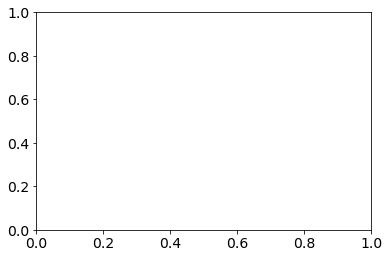

In [5]:
def zplot2(z, ax=plt.gca(), lw=1.5, line_color='k'):
    ax.plot(np.real(z), np.imag(z), line_color, lw=lw)
def runge_kutta_stability_regions():
    z = np.exp(1j * np.pi * np.arange(201)/100.)
    r = z-1
    d = 1-1./z;
    # Order 1
    W1, W2, W3, W4 = [0], [0], [0], [0]
    for zi in z[1:]:
        W1.append( W1[-1]-(1.+W1[-1]-zi) )
    for zi in z[1:]:
        W2.append( W2[-1]-(1+W2[-1]+.5*W2[-1]**2-zi**2)/(1+W2[-1]) )
    for zi in z[1:]:
        num = (1+W4[-1]+.5*W4[-1]**2+W4[-1]**3/6+W4[-1]**4/24-zi**4)
        den = (1+W4[-1]+W4[-1]**2/2+W4[-1]**3/6.)
        W4.append( W4[-1] - num/den )
    return W1, W2, W4
W1,W2,W4=runge_kutta_stability_regions()

Text(0.5, 1.0, 'Stability Regions of some Runge-Kutta ODE solvers')

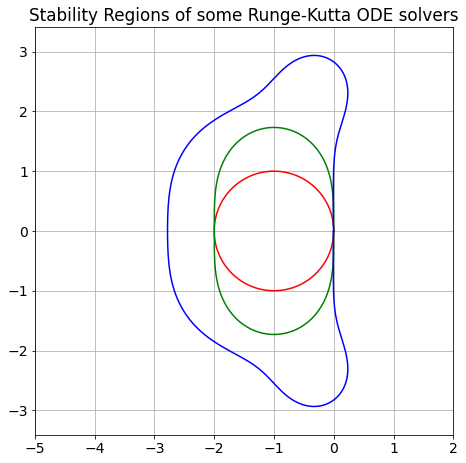

In [6]:
fig = plt.figure(figsize=(L/2,L/2))
ax=fig.gca()
zplot2(W1,ax,line_color='r')
zplot2(W2,ax,line_color='g')
zplot2(W4,ax,line_color='b')
ax.axis("equal")
ax.axis([-5, 2, -3.5, 3.5])
ax.grid("on")
ax.set_title("Stability Regions of some Runge-Kutta ODE solvers")

### Entonces, ¿cómo utilizamos la región de estabilidad?

Lo importante de este análisis es notar que no podemos definir $h$ a priori. Dados un método y $\lambda$ conocidos, debemos estudiar la región de estabilidad para determinar que valor de $h$ utilizar.

In [7]:
def plot_log_eq_stability_region(y0=1.2, h=0.5, T=10):
    # How did I get this? Why do I need it?
    def my_f_1D_prime(y):
        return np.array(1-2*y)

    # Choosing which solver to use
    solvers = ('euler','RK2','RK4')
    solver = solvers[2]

    t_times = np.arange(0, T+h, h)
    y_output = np.zeros(t_times.size)
    y_output[0] = y0

    for i in range(1,t_times.size):
        if solver=='euler':
            y_output[i]=euler_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
            c1,c2,c3='b','k','k'
        elif solver=='RK2':
            y_output[i]=RK2_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
            c1,c2,c3='k','b','k'
        else:
            y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
            c1,c2,c3='k','k','b'

    fig = plt.figure(figsize=(L,L))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)

    ax1.axis("equal")
    ax1.grid(True)
    ax1.set_title("Numerical Approximation")
    ax1.axis([0, T, -0.5, 2])
    ax1.plot(t_times,y_output,'-')
    ax1.plot(t_times,y_output,'.k')

    # The next code is to plot in logscale unstable numerical simulations
    y_all=h*my_f_1D_prime(y_output)
    y_pos=y_all>0
    y_neg=np.logical_not(y_pos)
    ax2.semilogy(t_times[y_pos],y_all[y_pos],'.r',ms=20)
    ax2.semilogy(t_times[y_neg],-y_all[y_neg],'.b',ms=20)
    ax2.grid("on")
    ax2.set_title("Numerical Approximation in log scale")

    zplot2(W1,ax3,line_color=c1)
    zplot2(W2,ax3,line_color=c2)
    zplot2(W4,ax3,line_color=c3)
    k_lambdah=h*my_f_1D_prime(y_output)
    ax3.plot(np.real(k_lambdah),np.imag(k_lambdah),'.r',ms=20)
    ax3.axis("equal")
    ax3.axis([-5, 2, -3.5, 3.5])
    ax3.grid("on")
    ax3.set_title("Stability Region and $k=\lambda\,h$")

#y0=1.2 # 1.2, 2.0, 4.0
#h=0.5  # 0.5, 0.1
#T=10
interact(plot_log_eq_stability_region,y0=(-2,5,0.1),h=(0.01,1,0.1), T=(1,20,1))

interactive(children=(FloatSlider(value=1.2, description='y0', max=5.0, min=-2.0), FloatSlider(value=0.5, desc…

<function __main__.plot_log_eq_stability_region(y0=1.2, h=0.5, T=10)>

<div id='conver' />

## Convergencia

¡Esto es muy importante! Estudiémoslo... 

Para hablar de convergencia, tenemos que tener en cuenta el orden de cada método. En palabras simples y resumidas podemos decir lo siguiente:

* Euler es un método de primer orden $O(h)$, por lo que si $h$ se reduce a la mitad, el error también lo hace.
* RK2 es un método de segundo orden $O(h^2)$, por lo que si $h$ se reduce a la mitad, el error se reduce a la cuarta parte.
* RK4 es un método de cuarto orden $O(h^4)$, por lo que si $h$ se reduce a la mitad, el error se reduce 16 veces.

Para ver esto, consideremos el siguiente problema:

\begin{align*}
\dot{y}(t)&=-3\,y(t)+6\,t+5\\
y(0)&=3
\end{align*}

cuya solución es $y(t)=2e^{-3t}+2t+1$.

In [8]:
y0=3.0
time_test=0.5
def my_f(t,y):
    return np.array(-3*y+6*t+5)
y_sol = lambda t: 2.*np.exp(-3.*t)+2.*t+1

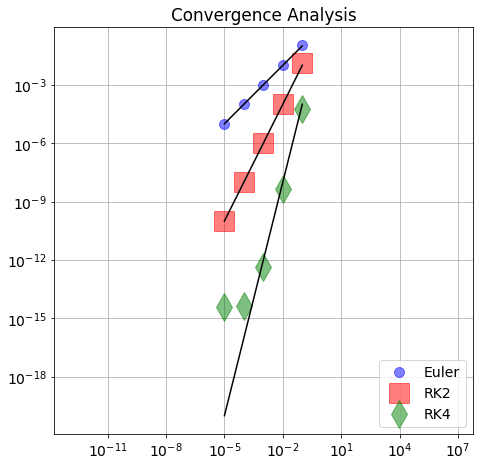

In [9]:
fig = plt.figure(figsize=(L/2,L/2))
fig.clf()
ax = fig.gca()
ax.axis("equal")
ax.grid(True)
ax.set_title("Convergence Analysis")

h_list = np.logspace(-5,-1,5)
for h in h_list:
    t_times = np.arange(0, time_test+h, h)
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=euler_ode(y_output[i-1],t_times[i-1],my_f,h)        
    plt.loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'b.',ms=20,label='Euler',alpha=.5)
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK2_ode(y_output[i-1],t_times[i-1],my_f,h)
    plt.loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'rs',ms=20,label='RK2',alpha=.5)
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],my_f,h)
    plt.loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'gd',ms=20,label='RK4',alpha=.5)
    if h==h_list[0]:
        plt.legend(numpoints=1, loc="lower right")
plt.loglog(h_list,h_list,'k-')
plt.loglog(h_list,np.power(h_list,2.),'k-')
plt.loglog(h_list,np.power(h_list,4.),'k-')

<div id='high' />

# Problemas de segundo orden y más dimensiones

¿Por qué debemos estudiar problemas de dimensiones más altas?

¡Porque son geniales!

### Van der pool

El ocsilador Van der Pol es un oscilador no conservativo con amortiguamiento no lineal. Su evolución en el tiempo sigue una ecuación diferencial de segundo orden: 

$$\ddot{y}-\mu\,(1-y^2)\,\dot{y} + y = 0$$ con $y(0)=2\ $   y   $\dot{y}(0)=0$

$\mu$ es un parámetro escalar que indica la no linealidad y la fuerza del amortiguamiento.

$y_1(t)=y(t)$ <br>
$y_2(t)=\dot{y}(t)$ <br> 
$\dot{y}_1=\dot{y} = y_2$ <br>
$\dot{y}_2=\ddot{y} = \mu (1-y^2) \dot{y} - y = \mu (1-y_1^2) y_2 - y_1$ <br> 

In [10]:
mu=10
def my_vdp(t,y,mu=mu):
    y1 = y[0]
    y2 = y[1]
    return np.array([y2, mu*(1-y1**2)*y2-y1])

def my_vdp_eig_jacobian(t,y,mu=mu):
    J=[[0,1],[-(2*mu*y[0]*y[1]+1), mu*(1-y[0]**2)]]
    lambs,vs= LA.eig(J)
    return lambs

In [11]:
def plotting_vdp(y01=2,y02=0,h=0.01,T=200,solver='euler'):
    y0=np.array([y01, y02])
    t_times = np.arange(0, T, h)
    y_output = np.zeros([t_times.size,2])
    y_output[0,:] = y0
    for i in range(1,t_times.size):
        #y_output[i,:]=euler_ode(y_output[i-1,:],t_times[i-1],my_vdp,h)
        if solver=='euler':
            y_output[i]=euler_ode(y_output[i-1],t_times[i-1],my_vdp,h)
        elif solver=='RK2':
            y_output[i]=RK2_ode(y_output[i-1],t_times[i-1],my_vdp,h)
        else:
            y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],my_vdp,h)

    fig = plt.figure(figsize=(L,L/2))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.grid(True)
    ax1.set_title("Numerical Approximation")
    ax1.plot(t_times,y_output[:,0],'-')
    ax1.set(xlabel='t', ylabel='$y_1$')
    ax1.plot(t_times,y_output[:,1],'-r')

    ax2.grid(True)
    ax2.set_title("Phase Portrait")
    ax2.plot(y_output[:,0],y_output[:,1],'-')
    ax2.set(xlabel='$y=y_1$', ylabel='$\dot{y}=y_2$')

interact(plotting_vdp,y01=(-3,3,0.1),y02=(-3,3,0.1),h=(0.001,1,0.01),T=(10,200,10),solver=['euler','RK2','RK4'])

interactive(children=(FloatSlider(value=2.0, description='y01', max=3.0, min=-3.0), FloatSlider(value=0.0, des…

<function __main__.plotting_vdp(y01=2, y02=0, h=0.01, T=200, solver='euler')>

### ¿Qué hay acerca de la región de estabilidad en sistemas dinámicos de EDO's?

In [12]:
def plotting_vpd_as_system(y01=2,y02=0,h=0.02,T=40,solver='euler'):
    t_times = np.arange(0, T+h, h)
    y_output = np.zeros([2,t_times.size])
    y_output[:,0] = y0

    for i in range(1,t_times.size):
        if solver=='euler':
            y_output[:,i]=euler_ode(y_output[:,i-1],t_times[i-1],my_vdp,h)
            c1='b'
            c2='k'
            c3='k'
        elif solver=='RK2':
            y_output[:,i]=RK2_ode(y_output[:,i-1],t_times[i-1],my_vdp,h)
            c1='k'
            c2='b'
            c3='k'
        else:
            y_output[:,i]=RK4_ode(y_output[:,i-1],t_times[i-1],my_vdp,h)
            c1='k'
            c2='k'
            c3='b'
    
    fig = plt.figure(figsize=(L,L))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    
    ax1.axis('equal')
    ax1.grid(True)
    ax1.set_title("Numerical Approximation")
    ax1.axis([0, T, -0.5, 2])
    ax1.plot(t_times,y_output[0,:],'-')
    ax1.plot(t_times,y_output[1,:],'r-')

    zplot2(W1,ax2,line_color=c1)
    zplot2(W2,ax2,line_color=c2)
    zplot2(W4,ax2,line_color=c3)
    for i in range(1,t_times.size):
        k_lambdah=h*my_vdp_eig_jacobian(t_times[i],y_output[:,i])
        ax2.plot(np.real(k_lambdah[0]),np.imag(k_lambdah[0]),'.r',ms=10,alpha=.4)
        ax2.plot(np.real(k_lambdah[1]),np.imag(k_lambdah[1]),'sm',ms=10,alpha=.4)
    ax2.axis('equal')
    ax2.axis([-5, 2, -3.5, 3.5])
    ax2.grid('on')
    
    ax3.grid(True)
    ax3.set_title("Phase Portrait")
    ax3.plot(y_output[0,:],y_output[1,:],'-')
    ax3.set(xlabel='$y=y_1$', ylabel='$\dot{y}=y_2$')

interact(plotting_vpd_as_system,y01=(-3,3,0.1),y02=(-3,-3,0.1),h=(0.01,1,0.01),T=(10,200,10),solver=['euler','RK2','RK4'])

interactive(children=(FloatSlider(value=2.0, description='y01', max=3.0, min=-3.0), FloatSlider(value=-3.0, de…

<function __main__.plotting_vpd_as_system(y01=2, y02=0, h=0.02, T=40, solver='euler')>

### Modelo Lotka-Volterra (ecuaciones predador-presa), es decir, lobos comiendo conejos y conejos escondiendo y comiendo pasto infinito.

Se definen $y_1(t)$ como el número de conejos en el tiempo $t$ y $y_2(t)$ como el número de lobos en el tiempo $t$. 
Todo esto está pasando en una isla, aunque estamos considerando la presencia de pasto infinito. Entonces, si no hay lobos, obtenemos $\dot{y1}(t)=y_1(t)$, en otras palabras, el número de conejos crece exponencialmente. 
Ahora, si no hubiesen conejos, obtenemos $\dot{y_2}(t)=-y_2(t)$, debido a que la población de lobos decae exponencialmente. Pero, ¿qué pasa si tenemos ambas especies?

\begin{align*}
\dot{y_1}(t)&=(1-y_2(t)/\mu_2)\,y_1(t)\\
\dot{y_2}(t)&=-(1-y_1(t)/\mu_1)\,y_2(t)\\
y_1(0)&=400\\
y_2(0)&=100
\end{align*}

donde $\mu_1$ y $\mu_2$ son constantes de normalización.

In [13]:
mu1=300
mu2=200
def f_predprey(t,y,mu1=mu1,mu2=mu2):
    y1 = y[0]
    y2 = y[1]
    return np.array([(1-y2/mu2)*y1, -(1-y1/mu1)*y2])

def f_predprey_jacobian(t,y,mu1=mu1,mu2=mu2):
    J=[[1-y[1]/mu2,-y[0]/mu2],[y[1]/mu1, -(1-y[0]/mu1)]]
    lambs,vs= LA.eig(J)
    return lambs

In [14]:
y0=[10, 100]
h=0.03
T=30

# Choosing which solver to use
solvers = ('euler','RK2','RK4')
solver = solvers[0]



def plotting_predprey(y01=70,y02=100,h=0.03,T=30,solver='euler'):
    t_times = np.arange(0, T+h, h)
    y_output = np.zeros([2,t_times.size])
    y_output[:,0] = y0
    y_output[0,0] = y01
    y_output[1,0] = y02

    for i in range(1,t_times.size):
        if solver=='euler':
            y_output[:,i]=euler_ode(y_output[:,i-1],t_times[i-1],f_predprey,h)
            c1='b'
            c2='k'
            c3='k'
        elif solver=='RK2':
            y_output[:,i]=RK2_ode(y_output[:,i-1],t_times[i-1],f_predprey,h)
            c1='k'
            c2='b'
            c3='k'
        else:
            y_output[:,i]=RK4_ode(y_output[:,i-1],t_times[i-1],f_predprey,h)
            c1='k'
            c2='k'
            c3='b'
    
    fig = plt.figure(figsize=(L,L))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    
    ax1.grid(True)
    ax1.set_title('Numerical Approximation')
    ax1.plot(t_times,y_output[0,:],'-')
    ax1.plot(t_times,y_output[1,:],'r-')
    ax1.axis([0, T, 0, 600])

    zplot2(W1,ax2,line_color=c1)
    zplot2(W2,ax2,line_color=c2)
    zplot2(W4,ax2,line_color=c3)
    for i in range(1,t_times.size):
        k_lambdah=h*my_vdp_eig_jacobian(t_times[i],y_output[:,i])
        ax2.plot(np.real(k_lambdah[0]),np.imag(k_lambdah[0]),'.r',ms=10,alpha=.4)
        ax2.plot(np.real(k_lambdah[1]),np.imag(k_lambdah[1]),'sm',ms=10,alpha=.4)
    ax2.axis('equal')
    ax2.axis([-5, 2, -3.5, 3.5])
    ax2.grid('on')
    
    ax3.grid(True)
    ax3.set_title('Phase Portrait')
    ax3.plot(y_output[0,:],y_output[1,:],'-')
    ax3.set(xlabel='$y_1$', ylabel='$y_2$')
    ax3.axis([0, 800, 0, 600])

interact(plotting_predprey,y01=(0,1000,10),y02=(0,1000,10),h=(0.01,1,0.01),T=(10,200,10),solver=['euler','RK2','RK4'])

interactive(children=(IntSlider(value=70, description='y01', max=1000, step=10), IntSlider(value=100, descript…

<function __main__.plotting_predprey(y01=70, y02=100, h=0.03, T=30, solver='euler')>

In [15]:
def f_trig(t,y):
    y1 = y[0]
    y2 = y[1]
    return np.array([y2, -y1])

def f_trig_jacobian(t,y):
    #J=[[0,1],[-1, 0]]
    #lambs,vs= LA.eig(J)
    lambs=np.array([0.+1.j, 0.-1.j])
    return lambs

def plotting_f_trig(y01=1,y02=0,h=0.2,T=100,solver='euler'):

    t_times = np.arange(0, T+h, h)
    y_output = np.zeros([2,t_times.size])
    y_output[:,0] = y0

    for i in range(1,t_times.size):
        if solver=='euler':
            y_output[:,i]=euler_ode(y_output[:,i-1],t_times[i-1],f_trig,h)
            c1='b'
            c2='k'
            c3='k'
        elif solver=='RK2':
            y_output[:,i]=RK2_ode(y_output[:,i-1],t_times[i-1],f_trig,h)
            c1='k'
            c2='b'
            c3='k'
        else:
            y_output[:,i]=RK4_ode(y_output[:,i-1],t_times[i-1],f_trig,h)
            c1='k'
            c2='k'
            c3='b'
    fig = plt.figure(figsize=(L,L))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    
    ax1.grid(True)
    ax1.set_title('Numerical Approximation')
    ax1.plot(t_times,y_output[0,:],'-')
    ax1.plot(t_times,y_output[1,:],'r-')

    zplot2(W1,ax2,line_color=c1)
    zplot2(W2,ax2,line_color=c2)
    zplot2(W4,ax2,line_color=c3)
    for i in range(1,t_times.size):
        k_lambdah=h*f_trig_jacobian(t_times[i],y_output[:,i])
        ax2.plot(np.real(k_lambdah[0]),np.imag(k_lambdah[0]),'.r',ms=10,alpha=.4)
        ax2.plot(np.real(k_lambdah[1]),np.imag(k_lambdah[1]),'sm',ms=10,alpha=.4)
    ax2.axis('equal')
    ax2.axis([-5, 2, -3.5, 3.5])
    ax2.grid('on')
    
    ax3.grid(True)
    ax3.set_title('Phase Portrait')
    ax3.plot(y_output[0,:],y_output[1,:],'-')
    ax3.set(xlabel='$y_1$', ylabel='$y_2$')


interact(plotting_f_trig,y01=(-2,2,0.1),y02=(-2,2,0.1),h=(0.01,1,0.01),T=(10,200,10),solver=['euler','RK2','RK4'])

interactive(children=(FloatSlider(value=1.0, description='y01', max=2.0, min=-2.0), FloatSlider(value=0.0, des…

<function __main__.plotting_f_trig(y01=1, y02=0, h=0.2, T=100, solver='euler')>

In [16]:
def f_exp(t,y):
    y1 = y[0]
    return np.array([-y1])
def f_exp_jac(t,y):
    return -1

def plotting_f_exp(y0=1,h=0.1,T=10,solver='euler'):

    t_times = np.arange(0, T+h, h)
    y_output = np.zeros([2,t_times.size])
    y_output[:,0] = y0

    for i in range(1,t_times.size):
        if solver=='euler':
            y_output[:,i]=euler_ode(y_output[:,i-1],t_times[i-1],f_exp,h)
            c1='b'
            c2='k'
            c3='k'
        elif solver=='RK2':
            y_output[:,i]=RK2_ode(y_output[:,i-1],t_times[i-1],f_exp,h)
            c1='k'
            c2='b'
            c3='k'
        else:
            y_output[:,i]=RK4_ode(y_output[:,i-1],t_times[i-1],f_exp,h)
            c1='k'
            c2='k'
            c3='b'
    
    fig = plt.figure(figsize=(L,L/2))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.grid(True)
    ax1.set_title('Numerical Approximation')
    ax1.plot(t_times,y_output[0,:],'.k')
    ax1.plot(t_times,y_output[0,:],'-',alpha=0.5)
    ax1.axis([0, T, -2, 2])

    zplot2(W1,ax2,line_color=c1)
    zplot2(W2,ax2,line_color=c2)
    zplot2(W4,ax2,line_color=c3)
    for i in range(1,t_times.size):
        k_lambdah=h*f_exp_jac(t_times[i],y_output[:,i])
        ax2.plot(np.real(k_lambdah),np.imag(k_lambdah),'.r',ms=10,alpha=.4)
    ax2.axis('equal')
    ax2.axis([-5, 2, -3.5, 3.5])
    ax2.grid('on')

interact(plotting_f_exp,y0=(-2,2,0.1),h=(0.01,10,0.01),T=(1,20,1),solver=['euler','RK2','RK4'])

interactive(children=(FloatSlider(value=1.0, description='y0', max=2.0, min=-2.0), FloatSlider(value=0.1, desc…

<function __main__.plotting_f_exp(y0=1, h=0.1, T=10, solver='euler')>

<div id='BVP' />

# Problemas de Valor de Frontera

Un problema de valor de frontera (BVP) corresponde a una ecuación diferencial ordinaria de la forma:
$$ y''(x) = f(x,y(x),y'(x)) $$
sujeta a condiciones de borde:
$$ y(a) = y_a $$
$$ y(b) = y_b $$
Intentemos resolver $y''(x)=4y(x)$, con $y(0)=y_0$ y $y(1)=y_n$.

<div id='DD' />

## Diferencias Finitas

Este método consiste en aproximar las derivadas de $y(x)$ mediante diferencias finitas, para luego resolver un sistema de ecuaciones lineales o no lineal.

Dentro de las más conocidas están:

* Forward Difference:
$$ y'(x) = \dfrac{y(x+h) - y(x)}{h} + O(h)$$

* Backward Difference:
$$ y'(x) = \dfrac{y(x) - y(x-h)}{h} + O(h)$$

* Central Difference:
$$ y'(x) = \dfrac{y(x+h) - y(x-h)}{2h} + O(h^2)$$

Y para aproximar la segunda derivada utilizamos:
\begin{align*}
y''(x) &= \dfrac{\text{Forward Difference } - \text{ Backward Difference}}{h} + O(h^2) \\
y''(x) &= \dfrac{\dfrac{y(x+h) - y(x)}{h} - \dfrac{y(x) - y(x-h)}{h}}{h} + O(h^2) \\
y''(x) &= \dfrac{y(x+h) - 2y(x) + y(x-h)}{h^2} + O(h^2) \\
\end{align*}

In [17]:
def solve_finite_difference_eq(I=4,y0=1,yn=3):
    # Spatial discretization, 'I' represents the number of intervals to be used.
    h=(1.-0)/I
    ## Boundarty conditions
    #y0=1.
    #y1=3.

    # Building Finite Difference Discretization
    deltas=-(2.+4.*(h**2.))
    A=toeplitz(np.append(np.array([deltas, 1.]), np.zeros(I-3)))
    # Building RHS
    b=np.append(-y0, np.zeros(I-3))
    b=np.append(b,-yn)
    # Solving the linear system of equations
    w=np.linalg.solve(A, b)
    # Adding back the boundary conditions into the solution
    w=np.append([y0], w)
    w=np.append(w,[yn])
    t_FD = np.linspace(0,1,I+1)
    w_FD = w 
    return t_FD, w_FD, A

def plot_solution_finite_difference_eq(I=4,y0=1,yn=3):
    
    # Solving by Finite Difference
    t_FD, w_FD, A = solve_finite_difference_eq(I,y0,yn)
    
    # Plotting
    fig = plt.figure(figsize=(L,L/2))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # Plotting the discrete solution
    ax1.grid(True)
    ax1.set_title("FD")
    ax1.plot(t_FD,w_FD,'.',ms=20)
    #ax1.axis([0, 1, 0, 3])
    ax1.grid("on")
    
    # Plotting the pattern and coefficients of the tri-diagonal matrix
    plot_matrices_with_values(ax2,A)
    
interact(plot_solution_finite_difference_eq,I=(3,25,1),y0=(-5,5,0.1),yn=(-5,5,0.1))

interactive(children=(IntSlider(value=4, description='I', max=25, min=3), FloatSlider(value=1.0, description='…

<function __main__.plot_solution_finite_difference_eq(I=4, y0=1, yn=3)>

<div id='MD' />

## Método de Disparo

Este método consiste en tratar el BVP como si fuera un IVP mediante las siguientes consideraciones:

* Teniendo el BVP $ y''(x) = f(x,y(x),y'(x)) $,con $ y(a) = y_a $ y $ y(b) = y_b $.
* Consideremos $x \rightarrow t$ y $ \ddot{y}(t) = f(t,y(t),\dot{y}(t)) $,con $ y(t_0) = y_0 $ y $ \dot{y}(t_0) = \alpha $.
* Y definamos la función $F(\alpha) = y(t_n,\alpha) - y_b$.

Entonces solo basta con encontrar una raíz de $F(\alpha)$ para que la solución de este IVP corresponda a la solución del BVP que en realidad estamos resolviendo.

In [22]:
def my_f(t,y):
    return np.array([y[1],4*y[0]])

In [23]:
alpha=-1.
N=100

def shooting_method_101(alpha=-1, N=50, I=4, y0=1, yn=3):
    T=1.0
    h=T/(N-1.)
    t_times = np.linspace(0,T,num=N)
    y_output = np.zeros([t_times.size,2])
    y_output[0,:] = [y0,alpha]
    for i in range(1,t_times.size):
        y_output[i,:]=euler_ode(y_output[i-1,:],t_times[i-1],my_f,h)
    
    fig = plt.figure(figsize=(L/2,L/2))
    ax = fig.gca()
    plt.grid(True)
    plt.title("Numerical Approximation")
    plt.plot(t_times,y_output[:,0],'rd',ms=12,alpha=0.5,label='y: actual solution')
    plt.plot(t_times,y_output[:,1],'m.',ms=12,alpha=0.5,label='$\dot{y}$: derivative of solution')
    
    # Solving by Finite Difference
    t_FD, w_FD, _ = solve_finite_difference_eq(I,y0,yn)
    plt.plot(t_FD,w_FD,'.',ms=20,alpha=1)
    
    # Plotting distance to be reduced, so the missing initial condition is found.
    plt.plot([t_FD[-1],t_times[-1]],[w_FD[-1],y_output[-1,0]],'g-',label='Difference to be reduced')
    
    plt.plot(0,1,'.k',ms=12,label='Left Boundary Condition')
    plt.plot(1,3,'.k',ms=12,label='Right Boundary Condition')
    
    plt.legend()

interact(shooting_method_101,alpha=(-2,2,0.1),N=(10,200,10),I=(3,20), y0=(-5,5,0.1),yn=(-5,5,0.1))

interactive(children=(FloatSlider(value=-1.0, description='alpha', max=2.0, min=-2.0), IntSlider(value=50, des…

<function __main__.shooting_method_101(alpha=-1, N=50, I=4, y0=1, yn=3)>

### Ahora hagámoslo automáticamente

In [35]:
N_grid = 100
def func(alpha):
    yn=3
    t_times,y_output = my_solver(N_grid,alpha)
    return y_output[-1,0]-yn

def my_solver(N,alpha):
    y0=1.
    T=1.0
    h=T/(N-1.)
    t_times = np.linspace(0,T,num=N)
    y_output = np.zeros([t_times.size,2])
    y_output[0,:] = [y0,alpha]
    for i in range(1,t_times.size):
        y_output[i,:]=RK4_ode(y_output[i-1,:],t_times[i-1],my_f,h)
    return t_times,y_output

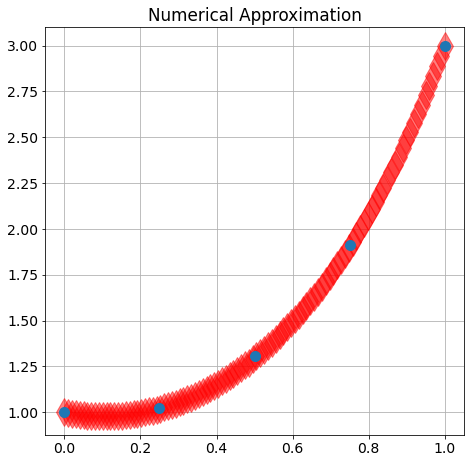

In [36]:
alpha = root(func, 0.)

t_times,y_output = my_solver(N_grid,alpha.x)

fig = plt.figure(figsize=(L/2,L/2))
#ax = fig.gca()
plt.grid(True)
plt.title("Numerical Approximation")
plt.plot(t_times,y_output[:,0],'rd',ms=20,alpha=0.5)
t_FD, w_FD, _ = solve_finite_difference_eq()
plt.plot(t_FD,w_FD,'.',ms=20,alpha=1)

In [26]:
alpha

    fjac: array([[-1.]])
     fun: 0.0
 message: 'The solution converged.'
    nfev: 5
     qtf: array([-1.33226763e-15])
       r: array([-1.81343016])
  status: 1
 success: True
       x: array([-0.42030605])

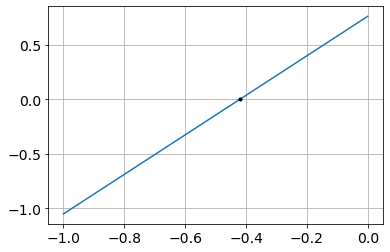

In [30]:
N = 100
alphas = np.linspace(-1,0,N)
fa = []
for a in alphas:
    fa.append(func(a))
faa = np.array(fa)
plt.figure()
plt.plot(alphas,faa)
plt.grid(True)
plt.plot([alpha.x],[0],'.k')
plt.show()

<div id='acknowledgements' />

# Acknowledgements
* _Material creado por profesor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _y ayudantes: Alvaro Salinas y Martín 
Villanueva. DI UTFSM. Abril 2016._

***
### DISCLAIMER ###

El presente notebook ha sido creado para el curso **ILI286 - Computación Científica 2**, del [Departamento de Informática](http://www.inf.utfsm.cl/), [Universidad Técnica Federico Santa María](http://www.utfsm.cl/). 

El material ha sido creado por Claudio Torres <ctorres@inf.utfsm.cl> y Sebastian Flores <sebastian.flores@usm.cl>, y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactarnos.

[Update 2015] Se ha actualizado los notebooks a Python 3 e includio el "magic" "%matplotlib inline" antes de cargar matplotlib para que los gráficos se generen en el notebook. 

[Update 2016] (Álvaro) Modificaciones mayores al formato original. Agregado contexto: Introducción, Tabla de Contenidos, Explicaciones de cada método.

[Update 2019] (C. Torres) Small changes. Fixing issue with title of sections and identation. Adding 'interact' to the logistic equation! Adding interact to everything, work in progress. All done, Enjoy!
***